In [ ]:
# %pip install

In [2]:
import os
import sys
import pandas as pd
import cv2
import time
import decimal
import json

import PIL
from PIL import Image
import numpy as np
import xml.etree.ElementTree as ET

from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow.python.keras import backend as K
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import GlobalAvgPool2D, Conv2D, Dense, Flatten, Dropout
from tensorflow.keras import activations
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import SGD
AUTOTUNE = tf.data.experimental.AUTOTUNE

import sklearn
import sklearn.model_selection
import sklearn.metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [3]:
breed_list= os.listdir('../stanford_dataset/Annotation')

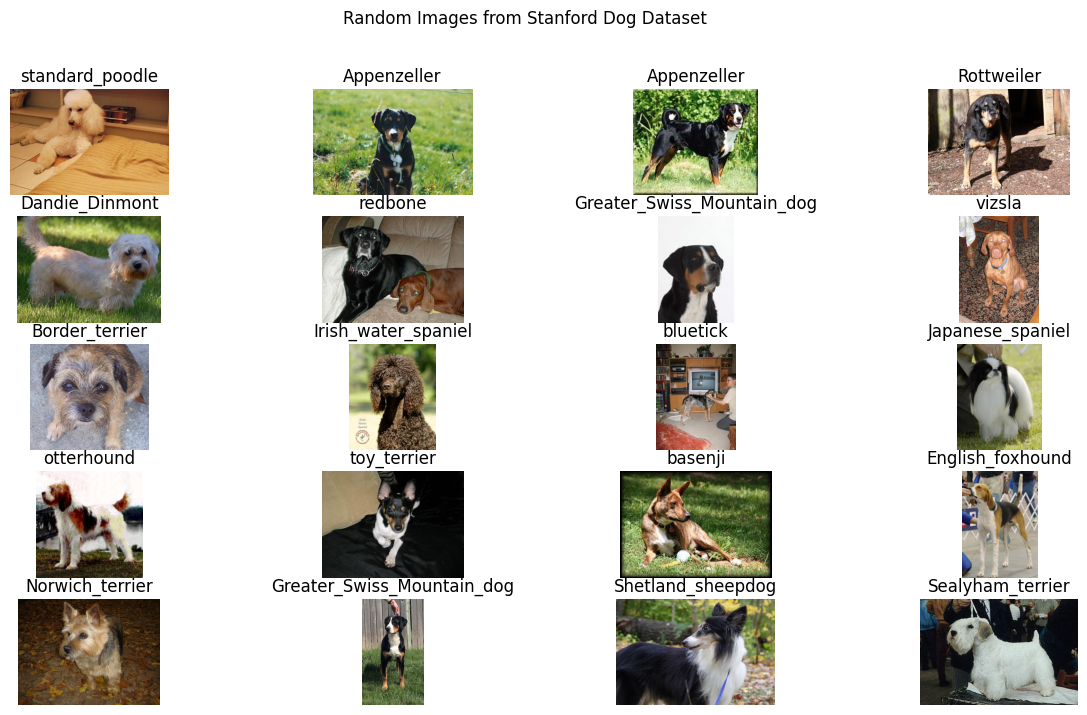

In [4]:
sample = plt.figure(figsize=(15,8))
for i in range(20):
    fig = sample.add_subplot(5,4,i+1)
    random_breed = np.random.choice(breed_list) # random breed
    random_dog = np.random.choice(os.listdir('../stanford_dataset/Annotation/' + random_breed)) #random file of the breed
    img = Image.open('../stanford_dataset/Images/' + random_breed + '/' + random_dog + '.jpg')
    tree = ET.parse('../stanford_dataset/Annotation/' + random_breed + '/' + random_dog) 
    #parses the data present in file of the dogs
    root = tree.getroot()
    find_dog = root.findall('object')[0]; #finds the dog info
    dog_breed = find_dog.find('name').text; #dog name inside the object 
    fig.set_title(dog_breed)
    plt.imshow(img)    
    plt.axis('off')

plt.suptitle("Random Images from Stanford Dog Dataset")
plt.show()

In [5]:
ET.dump(tree)

<annotation>
	<folder>02095889</folder>
	<filename>n02095889_10</filename>
	<source>
		<database>ImageNet database</database>
	</source>
	<size>
		<width>320</width>
		<height>216</height>
		<depth>3</depth>
	</size>
	<segment>0</segment>
	<object>
		<name>Sealyham_terrier</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>51</xmin>
			<ymin>36</ymin>
			<xmax>271</xmax>
			<ymax>207</ymax>
		</bndbox>
	</object>
</annotation>


In [6]:
breed_list = os.listdir('../stanford_dataset/Annotation/')
breed_list.sort()
# Create label index for easy lookup
label2index = dict((dog_breed, index) for index, dog_breed in enumerate(breed_list))
index2label = dict((index, dog_breed) for index, dog_breed in enumerate(breed_list))

images = []
annotations =[]
for random_breed in breed_list:
  image_files = os.listdir('../stanford_dataset/Images/' + random_breed)
  image_files.sort()
  
  images.extend([os.path.join('../stanford_dataset/Images/', random_breed,f).replace("\\","/") for f in image_files])
  annotations.extend([os.path.join('../stanford_dataset/Annotaion/', random_breed,f.replace(".jpg","")).replace("\\","/") for f in image_files])

for idx, ann in enumerate(annotations):
  annotations[idx] = ann.split("/")[3]

# Prepare train test validate datasets
Xs = np.asarray(images)
Ys = np.asarray(annotations)

print('Xs shape',Xs.shape)
print(Xs[:3])
print('Ys shape',Ys.shape)
print(Ys[:3])

# Split into train_validate + test data
train_validate_x, test_x, train_validate_y, test_y = train_test_split(Xs,Ys,test_size=0.1)

print("\ntrain_validate_x shape:",train_validate_x.shape)
print('train_validate_x:',train_validate_x[:3])
print("train_validate_y shape:",train_validate_y.shape)
print('train_validate_y:',train_validate_y[:3])

print("\ntest_x shape:",test_x.shape)
print('test_x:',test_x[:3])
print("test_y shape:",test_y.shape)
print('test_y:',test_y[:3])

Xs shape (20580,)
['../stanford_dataset/Images/n02085620-Chihuahua/n02085620_10074.jpg'
 '../stanford_dataset/Images/n02085620-Chihuahua/n02085620_10131.jpg'
 '../stanford_dataset/Images/n02085620-Chihuahua/n02085620_10621.jpg']
Ys shape (20580,)
['n02085620-Chihuahua' 'n02085620-Chihuahua' 'n02085620-Chihuahua']

train_validate_x shape: (18522,)
train_validate_x: ['../stanford_dataset/Images/n02106662-German_shepherd/n02106662_13368.jpg'
 '../stanford_dataset/Images/n02091134-whippet/n02091134_1129.jpg'
 '../stanford_dataset/Images/n02097130-giant_schnauzer/n02097130_4888.jpg']
train_validate_y shape: (18522,)
train_validate_y: ['n02106662-German_shepherd' 'n02091134-whippet'
 'n02097130-giant_schnauzer']

test_x shape: (2058,)
test_x: ['../stanford_dataset/Images/n02095570-Lakeland_terrier/n02095570_315.jpg'
 '../stanford_dataset/Images/n02112018-Pomeranian/n02112018_3917.jpg'
 '../stanford_dataset/Images/n02108089-boxer/n02108089_13526.jpg']
test_y shape: (2058,)
test_y: ['n02095570

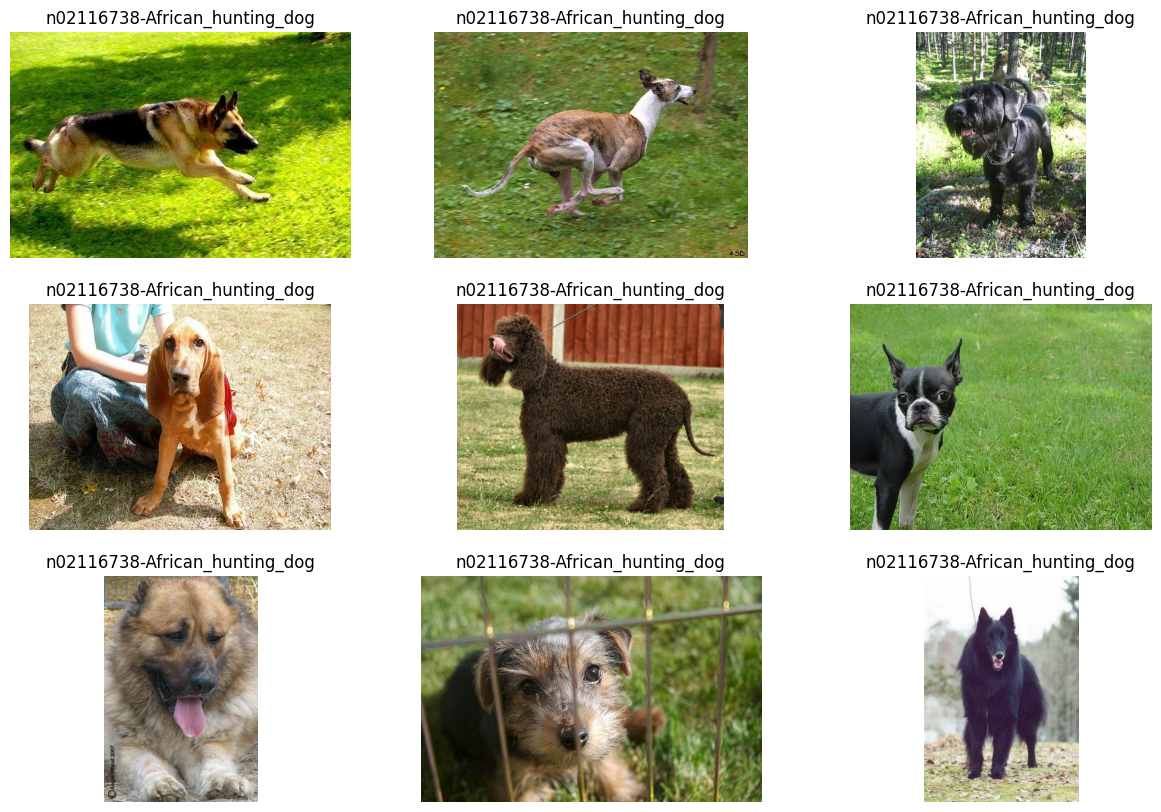

In [7]:
# View a few train images
sample = plt.figure(figsize=(15,10))

for idx in range(9):
  sample_input = cv2.imread(train_validate_x[idx])
  sample_input = cv2.cvtColor(sample_input, cv2.COLOR_BGR2RGB)
  breed = train_validate_y[idx];
  fig = sample.add_subplot(3,3,idx+1)
  fig.set_title(random_breed)
  plt.imshow(sample_input)
  plt.axis('off')

plt.show();

In [ ]:
validation_percent = 0.2
image_width = 128
image_height = 128
num_channels = 3
num_classes = len(breed_list)

epochs = 10
train_batch_size = 64
validation_batch_size = 64
test_batch_size = 64
train_shuffle_size = train_batch_size * 3
validation_shuffle_size = validation_batch_size * 3

train_x, validate_x, train_y, validate_y = train_test_split(train_validate_x, train_validate_y, test_size= validation_percent)

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Rescale images
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

#  Converts to binary class matrix (One-hot-encoded)
train_processed_y = np.asarray([label2index[label] for label in train_y])
validate_processed_y = np.asarray([label2index[label] for label in validate_y])
test_processed_y = np.asarray([label2index[label] for label in test_y])
train_processed_y = to_categorical(train_processed_y, num_classes=num_classes)
validate_processed_y = to_categorical(validate_processed_y, num_classes=num_classes)
test_processed_y = to_categorical(test_processed_y, num_classes=num_classes)

train_data_count = train_x.shape[0]
steps_per_epoch = int(train_data_count / train_batch_size)
validation_data_count = validate_x.shape[0]
validation_steps = int(validation_data_count / validation_batch_size)

# Define Data Processing Functions
def load_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=num_channels)
    image = tf.image.resize(image, [image_height, image_width])
    return image, label

def normalize(image, label):
    image = image / 255.0  # Normalize pixel values to [0, 1]
    return image, label

# Build Data Generators
def build_data_generators():
    # Create TF Datasets
    train_data = tf.data.Dataset.from_tensor_slices((train_x, train_processed_y))
    validation_data = tf.data.Dataset.from_tensor_slices((validate_x, validate_processed_y))
    test_data = tf.data.Dataset.from_tensor_slices((test_x, test_processed_y))

    # Train Data Processing
    train_data = train_data.shuffle(train_data_count)
    train_data = train_data.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    train_data = train_data.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)
    train_data = train_data.repeat().batch(train_batch_size).prefetch(tf.data.AUTOTUNE)

    # Validation Data Processing
    validation_data = validation_data.shuffle(validation_data_count)
    validation_data = validation_data.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    validation_data = validation_data.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)
    validation_data = validation_data.repeat().batch(validation_batch_size).prefetch(tf.data.AUTOTUNE)

    # Test Data Processing
    test_data = test_data.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    test_data = test_data.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)
    test_data = test_data.batch(test_batch_size).prefetch(tf.data.AUTOTUNE)

    return train_data, validation_data, test_data

# Create the Data Generators
train_data, validation_data, test_data = build_data_generators()

# Debug Prints
print("Train data:", train_data)
print("\nValidation data:", validation_data)
print("\nTest data:", test_data)


Train data: <PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.float32, name=None))>

Validation data: <PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.float32, name=None))>

Test data: <PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.float32, name=None))>


In [34]:
# Custom JSON Encoder for complex data types
class JsonEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(JsonEncoder, self).default(obj)

# Save model metrics to a JSON file
def save_model_metrics(model_name="xception", metrics={}):
    if os.path.exists("../SavedModels/model_metrics.json"):
        with open("../SavedModels/model_metrics.json") as json_file:
            model_metrics = json.load(json_file)
    else:
        model_metrics = {}

    model_metrics[model_name] = metrics

    # Save the JSON
    with open("../SavedModels/model_metrics.json", 'w') as json_file:
        json_file.write(json.dumps(model_metrics, cls=JsonEncoder))

# Save model structure, weights, and history
def save_model(path="../SavedModels", model_name="xception", model=None):
    os.makedirs(path, exist_ok=True)
    # Save the entire model
    model.save(os.path.join(path, model_name + ".hdf5"))
    # Save only weights
    model.save_weights(os.path.join(path, model_name + ".h5"))
    # Save structure only
    model_json = model.to_json()
    with open(os.path.join(path, model_name + ".json"), "w") as json_file:
        json_file.write(model_json)

# Get model size
def get_model_size(path="../SavedModels", model_name="xception"):
    model_size = os.stat(os.path.join(path, model_name + ".hdf5")).st_size
    return model_size

# Evaluate, save, and log model details
def evaluate_save_model(model, training_results, test_data, execution_time, learning_rate, batch_size, epochs, optimizer, momentum=None, save=True):
    # Get training history
    model_train_history = training_results.history
    num_epochs = len(model_train_history["loss"])

    # Plot training results
    fig = plt.figure(figsize=(15, 5))
    axs = fig.add_subplot(1, 2, 1)
    axs.set_title('Loss')
    for metric in ["loss", "val_loss"]:
        axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
    axs.legend()

    axs = fig.add_subplot(1, 2, 2)
    axs.set_title('Accuracy')
    for metric in ["accuracy", "val_accuracy"]:
        axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
    axs.legend()
    plt.show()

    # Evaluate on test data
    evaluation_results = model.evaluate(test_data)
    print('Evaluation results: [loss, accuracy]', evaluation_results)

    if save:
        # Save the model
        save_model(model_name=model.name, model=model)
        model_size = get_model_size(model_name=model.name)

        # Save model history
        with open(os.path.join("../SavedModels", model.name + "_train_history.json"), "w") as json_file:
            json_file.write(json.dumps(model_train_history, cls=JsonEncoder))

        # Save model metrics
        trainable_parameters = model.count_params()
        metrics = {
            "trainable_parameters": trainable_parameters,
            "execution_time": execution_time,
            "loss": evaluation_results[0],
            "accuracy": evaluation_results[1],
            "model_size": model_size,
            "learning_rate": learning_rate,
            "batch_size": batch_size,
            "momentum": momentum,
            "epochs": epochs,
            "optimizer": type(optimizer).__name__,
        }
        save_model_metrics(model_name=model.name, metrics=metrics)

In [52]:
view_metrics = pd.read_json("../SavedModels/model_metrics.json")
view_metrics = view_metrics.T
# Format columns
view_metrics['accuracy'] = view_metrics['accuracy']*100
view_metrics['accuracy'] = view_metrics['accuracy'].map('{:,.2f}%'.format)

view_metrics['trainable_parameters'] = view_metrics['trainable_parameters'].map('{:,.0f}'.format)
view_metrics['execution_time'] = view_metrics['execution_time'].map('{:,.2f} mins'.format)
#view_metrics['loss'] = view_metrics['loss'].map('{:,.2f}'.format)
view_metrics['model_size'] = view_metrics['model_size']/1000000
view_metrics['model_size'] = view_metrics['model_size'].map('{:,.0f} MB'.format)
print('Number of models:',view_metrics.shape[0])

Number of models: 2


In [26]:
xception_model = Xception(include_top=False, weights='imagenet', input_shape=(image_height,image_width,3))

def view_layers(model):
    layers = model.layers
    layers_list = []

    for idx, layer in enumerate(layers):
        layers_list.append({
            'layer': type(layer).__name__,
            'trainable':layer.trainable
        })

    df = pd.DataFrame(layers_list)

    return df

layers_df = view_layers(xception_model)
print(layers_df[10:])

                  layer  trainable
10      SeparableConv2D       True
11   BatchNormalization       True
12               Conv2D       True
13         MaxPooling2D       True
14   BatchNormalization       True
..                  ...        ...
127  BatchNormalization       True
128          Activation       True
129     SeparableConv2D       True
130  BatchNormalization       True
131          Activation       True

[122 rows x 2 columns]


In [27]:
print(len(xception_model.layers))

132


In [36]:

# Training Params
learning_rate = 0.001
batch_size = 64
epochs = 30
# Set all layers as trainable false execpt last conv block for faster training
def build_xception_model(model_name='xception', print_summary=True):
    for layer in xception_model.layers:
        layer.trainable = False

    # Input
    model_input = xception_model.input

    # Final pool layer
    hidden = xception_model.layers[-1]
    print("Pool Layer",hidden)

    # Flatten
    hidden = Flatten()(hidden.output)

    #  Hidden Layer, Classification Block
    hidden = Dense(units=1024, activation='relu')(hidden)
    hidden = Dropout(0.5)(hidden)

    # Output Layer
    output = Dense(units=120, activation='softmax')(hidden)

    # Build model
    model = Model(inputs=model_input, outputs=output, name=model_name)

    # Optimizer
    optimizer = optimizer = tf.keras.optimizers.Adam()

    # Loss
    loss = losses.CategoricalCrossentropy()

    # Compile
    model.compile(loss=loss,
        optimizer= optimizer,
        metrics=['accuracy']) 
    print(model.summary())
    return model
    




Training

In [30]:
def adjust_brightness(image, label):
    return tf.image.adjust_brightness(image, 0.01), label
def adjust_contrast(image, label):
    return tf.image.adjust_contrast(image, 1.2), label

# Apply data processing + data augmentation steps
data_process_list=[load_image, normalize, adjust_brightness, adjust_contrast]

# Build data generators for train, validate, test
train_data, validation_data, test_data = build_data_generators()
print("train_data",train_data)
print("validation_data",validation_data)
print("test_data",test_data)

train_data <PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.float32, name=None))>
validation_data <PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.float32, name=None))>
test_data <PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.float32, name=None))>


In [48]:
earlystopping = EarlyStopping(monitor='val_accuracy', patience=10)

# Model Checkpoint
checkpoint_filepath = '../Checkpoints/new.keras'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    verbose=1,
    mode='max',
    save_best_only=True)

model= load_model('../SavedModels/highaccuracy.h5')
start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data=validation_data,
        callbacks=[earlystopping,model_checkpoint_callback],
        epochs=epochs,
        verbose=1,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

Epoch 1/30
231/231 [==============================] - ETA: 0s - loss: 0.9357 - accuracy: 0.7755
Epoch 1: val_accuracy improved from -inf to 0.82538, saving model to ../Checkpoints\new.keras
231/231 [==============================] - 25s 100ms/step - loss: 0.9357 - accuracy: 0.7755 - val_loss: 0.7302 - val_accuracy: 0.8254
Epoch 2/30
231/231 [==============================] - ETA: 0s - loss: 0.5839 - accuracy: 0.8450
Epoch 2: val_accuracy did not improve from 0.82538
231/231 [==============================] - 18s 79ms/step - loss: 0.5839 - accuracy: 0.8450 - val_loss: 0.7561 - val_accuracy: 0.8191
Epoch 3/30
231/231 [==============================] - ETA: 0s - loss: 0.3544 - accuracy: 0.9033
Epoch 3: val_accuracy did not improve from 0.82538
231/231 [==============================] - 18s 78ms/step - loss: 0.3544 - accuracy: 0.9033 - val_loss: 0.8116 - val_accuracy: 0.8029
Epoch 4/30
231/231 [==============================] - ETA: 0s - loss: 0.2310 - accuracy: 0.9354
Epoch 4: val_accurac

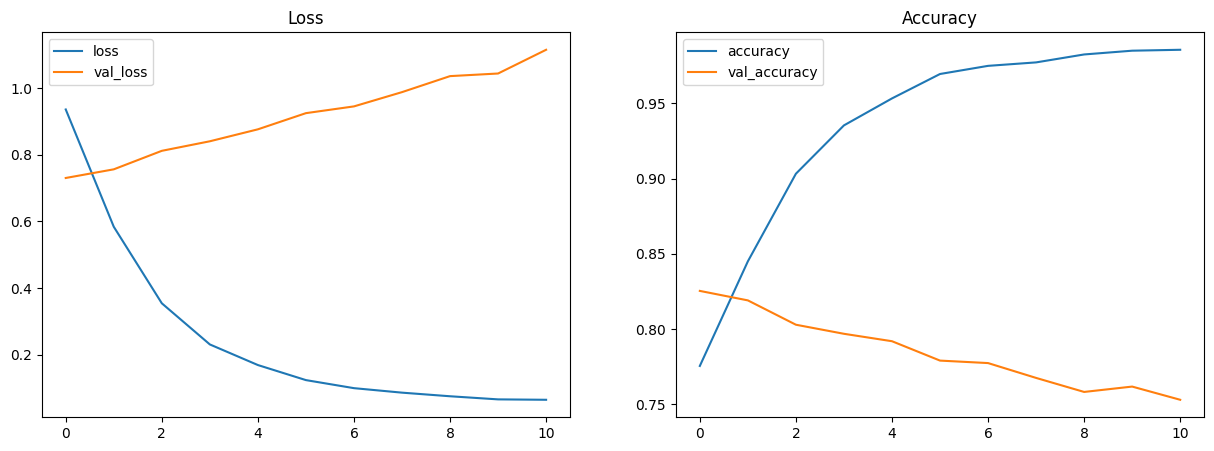

33/33 [==============================] - 2s 50ms/step - loss: 1.1644 - accuracy: 0.7454
Evaluation results: [loss, accuracy] [1.1644415855407715, 0.7453838586807251]


In [ ]:

evaluate_save_model(model,training_results,test_data,execution_time, learning_rate, batch_size, epochs, optimizer)


INFO:tensorflow:Assets written to: ../SavedModels/new_model\assets


INFO:tensorflow:Assets written to: ../SavedModels/new_model\assets


33/33 [==============================] - 2s 51ms/step


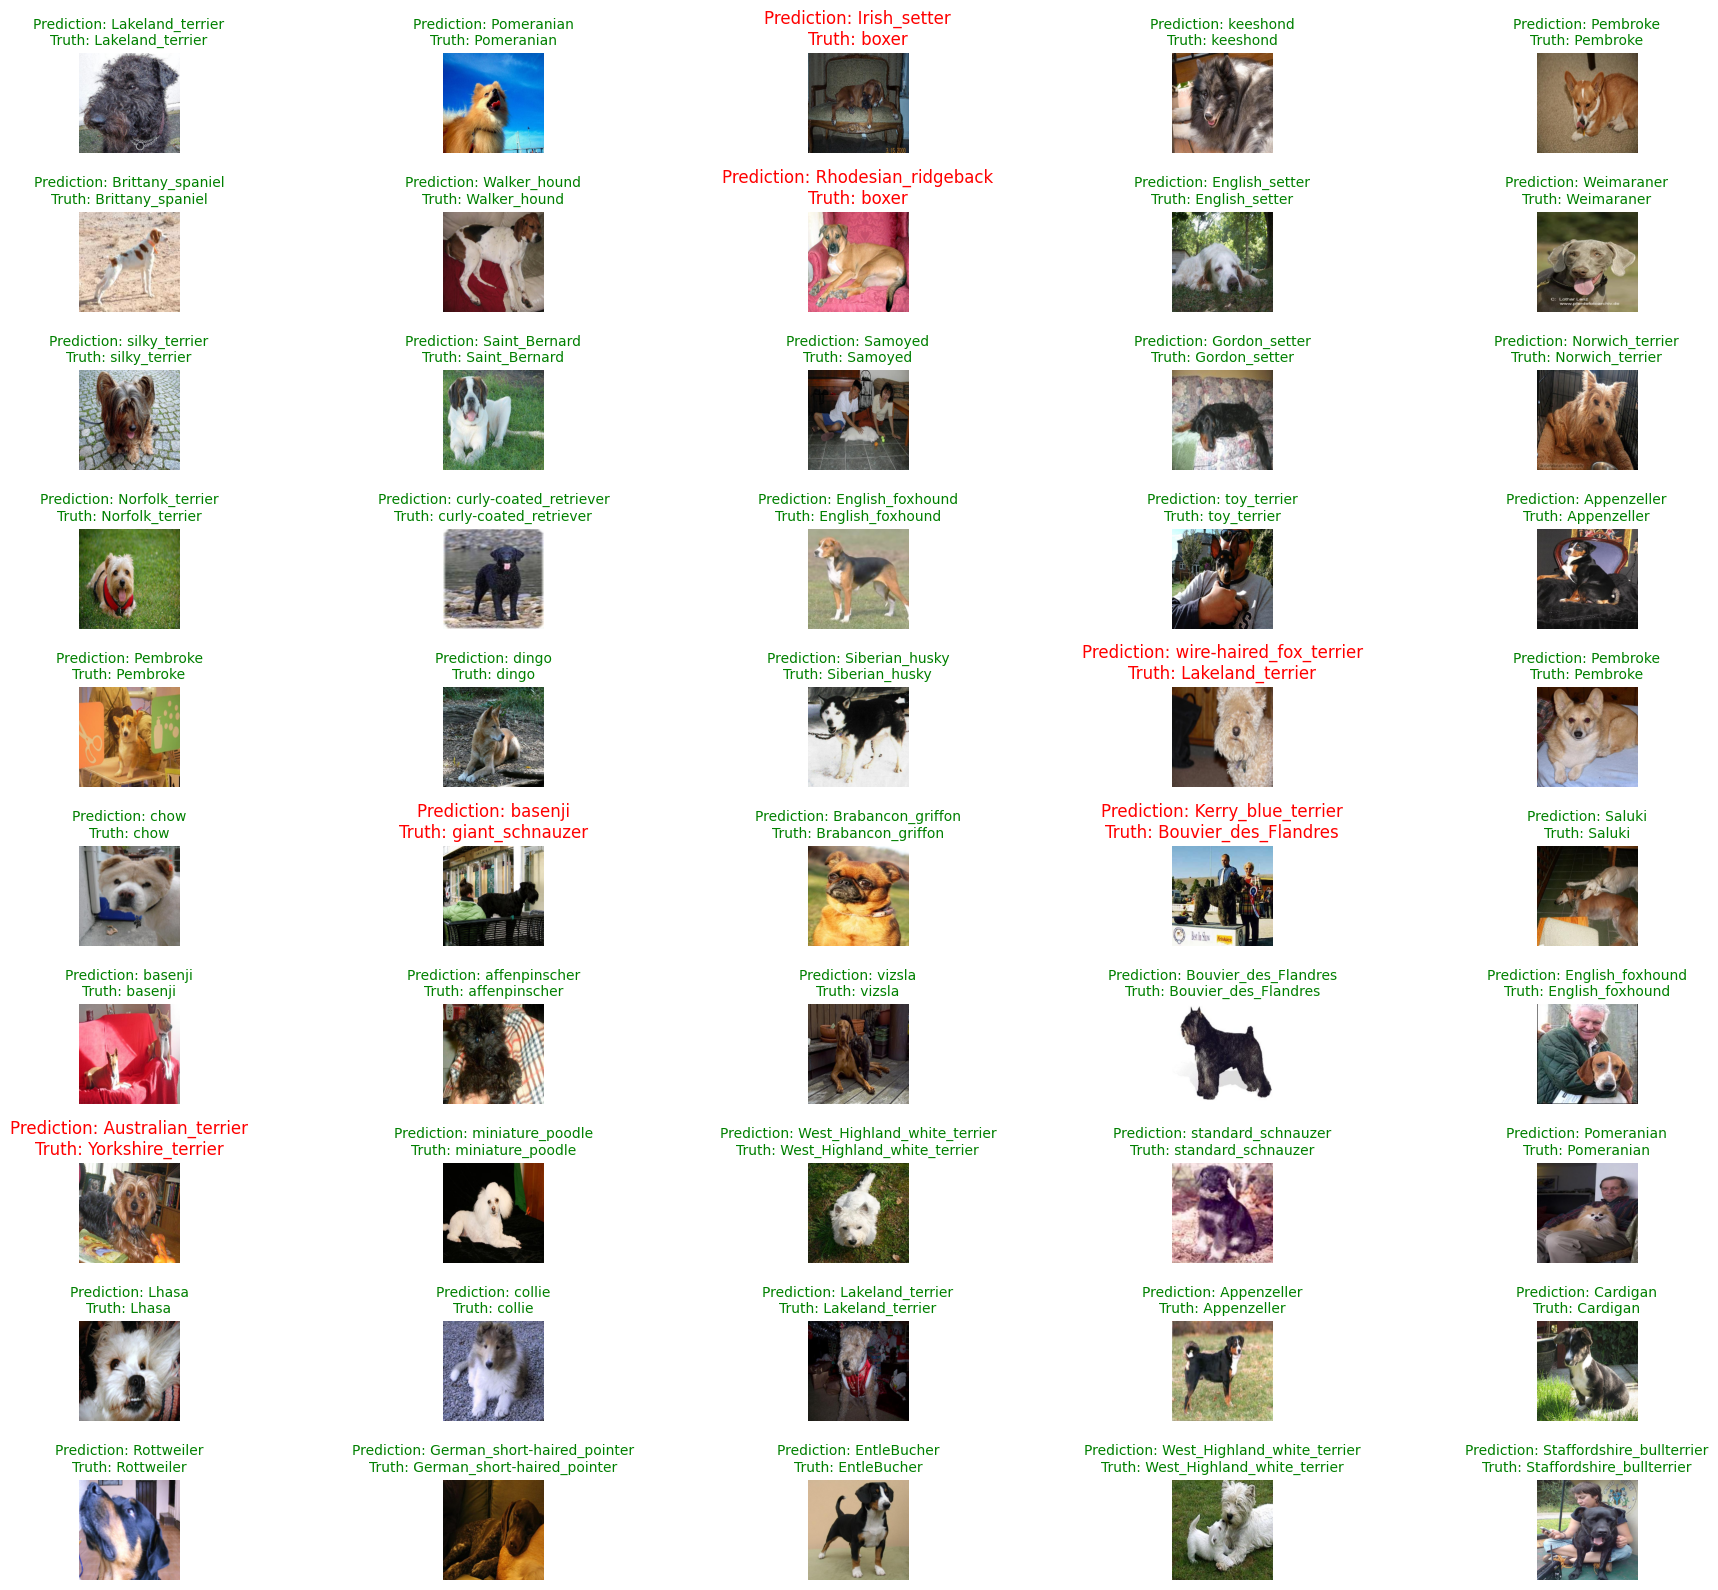

# of true predictions:  44
# of false predictions:  6


In [50]:
os.makedirs('../SavedModels', exist_ok=True)
model.save("../SavedModels/new_model.h5")
model.save("../SavedModels/new_model", save_format="tf")
prediction_model = tf.keras.models.load_model('../Checkpoints/new.keras')

# make predictions
test_predictions = prediction_model.predict(test_data)
image_size = (224, 224)

# Load Test images
test_x_display = []
for path in test_x:
    
    image = cv2.imread(path) # read image    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # convert to rgb
    image= cv2.resize(image, image_size) # resize
    
    test_x_display.append(image) # Train x

# Convert to numpy array
test_x_display = np.asarray(test_x_display)

# add true and predicted breed for each dog image
# mark it green if prediction is true, otherwise red
# count the total number of true predictions for the first 100 images
true_predict = 0
false_predict = 0
fig = plt.figure(figsize=(20,16))

for i,file in enumerate(test_x_display[:min(len(test_x_display), 50)]):
    axs = fig.add_subplot(10,5,i+1)
    axs.set_aspect('equal')
    
    predicted_breed = index2label[test_predictions.argmax(axis=1)[i]][10:] # [10:] truncates leading unnecessary letters
    true_breed = test_y[i][10:]
    
    # color code true/false predictions
    if true_breed == predicted_breed:
      axs.set_title('Prediction: ' + predicted_breed + '\n' + 'Truth: ' + true_breed,color='green', fontsize=10)
      true_predict += 1
    else:
      axs.set_title('Prediction: ' + predicted_breed + '\n' + 'Truth: ' + true_breed,color='red')
      false_predict += 1
      
    plt.imshow(test_x_display[i])
    plt.axis('off')
    
plt.tight_layout()
plt.show()

print('# of true predictions: ', true_predict)
print('# of false predictions: ', false_predict)

In [53]:
view_metrics.sort_values(by=['accuracy'],ascending=False).head(10)

trainable_parameters execution_time      loss accuracy model_size  \
Xception           54,539,936      3.46 mins  1.164442   74.54%     513 MB   
xception           54,539,936      6.70 mins  2.370339   43.44%     488 MB   

         learning_rate batch_size momentum epochs optimizer  
Xception         0.001         64     None     30      Adam  
xception         0.001         64     None     30      Adam

In [45]:
checkpoint_high_accuracy= load_model('../Checkpoints/checkpoint.keras')
checkpoint_high_accuracy.save('../SavedModels/highaccuracy.h5')

In [46]:
checkpoint_high_accuracy.summary()

Model: "Xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 63, 63, 32)   864         ['input_5[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 63, 63, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                           